In [1]:
from transformers_fixed import AutoModelForCausalLM, AutoTokenizer
import torch 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

### Model Import

In [2]:


# model_name = "EleutherAI/llemma_7b"
model_name = 'huggyllama/llama-7b'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)
model.eval()

def ret_queries(sent, model=model):
    """
    return (n_layers, n_heads, emb_query)
    """
    inputs = tokenizer(sent, return_tensors="pt").to("cuda")
    # splitted_text = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    model.forward(**inputs)
    qk_dict = model.get_qk_dict()
    queries = torch.stack([qk['query'] for l, qk in qk_dict.items()]).squeeze()

    return queries

def ret_keys(sent, model=model):
    """
    return (n_layers, n_heads, emb_query)
    """
    inputs = tokenizer(sent, return_tensors="pt").to("cuda")
    # splitted_text = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    model.forward(**inputs)
    qk_dict = model.get_qk_dict()
    queries = torch.stack([qk['key'] for l, qk in qk_dict.items()]).squeeze()

    return queries

model.device

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

device(type='cuda', index=0)

### Dataset preparing

![](./imgs/dataset.jpg)

In [3]:
import json

with open('./squad/train-v2.0.json', 'rt') as f:
    ds = json.load(f)

In [4]:
# Parsing json to DataFrame

res = []
for curr in ds['data']:
    title = curr['title']
    for par in curr['paragraphs']:
        context = par['context']
        for qa in par['qas']:
            question = qa['question']
            id = qa['id']
            ans = qa['answers']
            is_imposs = qa['is_impossible']

            res.append([title, context, question, ans, id, is_imposs])
        
df = pd.DataFrame(res, columns=['title', 'context', 'question', 'answer', 'id', 'is_impossible'])
df

,title,context,question,answer,id,is_impossible
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"[{'text': 'in the late 1990s', 'answer_start':...",56be85543aeaaa14008c9063,False
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"[{'text': 'singing and dancing', 'answer_start...",56be85543aeaaa14008c9065,False
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"[{'text': '2003', 'answer_start': 526}]",56be85543aeaaa14008c9066,False
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"[{'text': 'Houston, Texas', 'answer_start': 166}]",56bf6b0f3aeaaa14008c9601,False
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"[{'text': 'late 1990s', 'answer_start': 276}]",56bf6b0f3aeaaa14008c9602,False
...,...,...,...,...,...,...
130314,Matter,"The term ""matter"" is used throughout physics i...",Physics has broadly agreed on the definition o...,[],5a7e070b70df9f001a875439,True
130315,Matter,"The term ""matter"" is used throughout physics i...",Who coined the term partonic matter?,[],5a7e070b70df9f001a87543a,True
130316,Matter,"The term ""matter"" is used throughout physics i...",What is another name for anti-matter?,[],5a7e070b70df9f001a87543b,True
130317,Matter,"The term ""matter"" is used throughout physics i...",Matter usually does not need to be used in con...,[],5a7e070b70df9f001a87543c,True


array([[<AxesSubplot: title={'center': 'question'}>]], dtype=object)

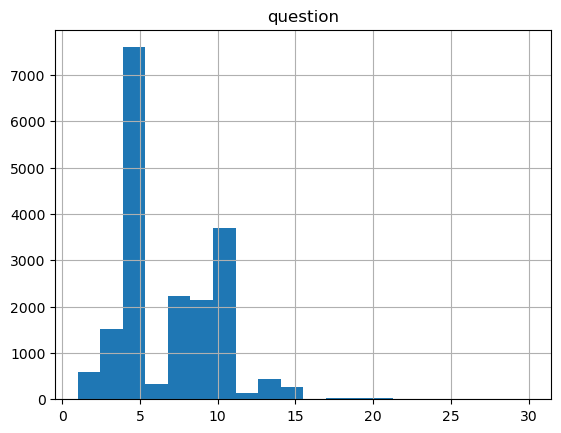

In [5]:
# Hist of number questions for one context

df.groupby('context').agg({'question': 'count'}).hist(bins=20)

In [6]:
# 1 - possible questions
# 0 - impossible questions 

df['answer'].apply(lambda x: len(x)).value_counts()

1    86821
0    43498
Name: answer, dtype: int64

In [7]:
# Filtering "nice" contexts and questions

# Context has only one '.' symbol 
sub_df = df.loc[df['context'].isin(list(filter(lambda x: x.count('.') == 1, df['context'].unique()))), :]

# Question has only one '?' symbol
sub_df = sub_df.loc[sub_df['question'].apply(lambda x: x.count('?')) == 1, :]

# Handcrafted feature (?): Context should has at least 1 impossible question and at lest 4 possible questions
count_df = sub_df.groupby('context').agg({'is_impossible': ['sum', 'count']})
nice_cont = count_df.loc[(count_df['is_impossible']['sum'] >= 1) & (count_df['is_impossible']['count'] - count_df['is_impossible']['sum'] >= 4) , :].index
print(len(nice_cont))

# Filter such "nice" contexts
nice_df = df.loc[df['context'].isin(nice_cont), :]
nice_df

86


,title,context,question,answer,id,is_impossible
2375,The_Legend_of_Zelda:_Twilight_Princess,A CD containing 20 musical selections from the...,What company included the soundtrack as a rewa...,"[{'text': 'GameStop', 'answer_start': 71}]",56cda64a62d2951400fa67be,False
2376,The_Legend_of_Zelda:_Twilight_Princess,A CD containing 20 musical selections from the...,How many tracks were recorded on the preorder CD?,"[{'text': '20', 'answer_start': 16}]",56cda64a62d2951400fa67bf,False
2377,The_Legend_of_Zelda:_Twilight_Princess,A CD containing 20 musical selections from the...,In what areas is the content of the GameStop b...,"[{'text': 'Japan, Europe, and Australia', 'ans...",56cda64a62d2951400fa67c0,False
2378,The_Legend_of_Zelda:_Twilight_Princess,A CD containing 20 musical selections from the...,What was included as a Gamestop preorder item?,"[{'text': 'CD', 'answer_start': 2}]",56d13400e7d4791d00901fdd,False
2379,The_Legend_of_Zelda:_Twilight_Princess,A CD containing 20 musical selections from the...,What company included the soundtrack as a rewa...,[],5a8dbd49df8bba001a0f9bb5,True
...,...,...,...,...,...,...
128102,Anthropology,Anthropology of development tends to view deve...,What does a lot of planned development apparen...,"[{'text': 'fail', 'answer_start': 527}]",5733cd1c4776f4190066127e,False
128103,Anthropology,Anthropology of development tends to view deve...,What tends to view development from a positive...,[],5ad2ee84604f3c001a3fd9ef,True
128104,Anthropology,Anthropology of development tends to view deve...,What field of anthropology has a goal to elevi...,[],5ad2ee84604f3c001a3fd9f0,True
128105,Anthropology,Anthropology of development tends to view deve...,What looks for the connections between plans a...,[],5ad2ee84604f3c001a3fd9f1,True


In [8]:
nice_df['question'].apply(lambda s: s.strip()[-1]).value_counts()

?    792
.      1
e      1
g      1
Name: question, dtype: int64

### Metric

Cosine Similarity:
$$CosSim(x, y) = \frac{x \cdot y}{\|x\|_2 \cdot \|y\|_2 }, \quad CosSim(x, y) \in [-1, 1]$$

Normed Cosine Similarity:
$$NormCosSim(x,y) = \frac{CosSim(x, y) + 1}{2}, \quad NormCosSim(x,y) \in [0, 1]$$

Triplet Cosine Similarity:
$$TriCos(a, p, n) = NormCosSim(a, p) - NormCosSim(a, n), \quad TriCos(a, p, n) \in [-1, 1],$$
where $a$ – anchor, $p$ – positive sample, $n$ – negative sample.

In [9]:
def normed_cosine_sim(a, b, dim=-1):
    res = torch.nn.CosineSimilarity(dim)(a, b)
    res = (res + 1) / 2
    return res

def triplet_cosine(anch, pos, neg, dim=-1):
    """
        RANGE = [-1, 1]
    """
    a_p = normed_cosine_sim(anch, pos, dim)
    a_n = normed_cosine_sim(anch, neg, dim)
    return a_p - a_n

### Query-Query

![](./imgs/raw_qa.jpeg)

In [10]:
from sklearn.model_selection import LeaveOneOut
from itertools import product
from tqdm.notebook import tqdm

all_losses = []
for curr_df in tqdm(nice_df.groupby('context')):
    curr_df = curr_df[1]
    pos_qa = curr_df.loc[~curr_df['is_impossible'], 'question'].to_list()
    impos_qa = curr_df.loc[curr_df['is_impossible'], 'question'].to_list()  

    stacked_pos = torch.stack([ret_queries(qa)[:, :, -1, :] for qa in pos_qa], dim=2)
    stacked_impos = torch.stack([ret_queries(qa)[:, :, -1, :] for qa in impos_qa], dim=2)

    loo = LeaveOneOut()

# avr-pos, 1 anchor,  3 neg 
    curr_triples = []
    for (train_idx, test_idx), impos_idx in product(loo.split(pos_qa), range(len(impos_qa))):
        # print(train_idx, test_idx, impos_idx)
        curr_anch = stacked_pos.index_select(2, torch.tensor(train_idx).cuda())
        curr_anch = curr_anch.mean(2)
        curr_pos = stacked_pos[:, :, test_idx[0], :]
        curr_neg = stacked_impos[:, :, impos_idx, :]

        # print(curr_pos.shape, curr_anch.shape, curr_neg.shape)
        loss = triplet_cosine(curr_anch, curr_pos, curr_neg)    
        # print(loss.shape)
        curr_triples.append(loss)
    curr_triples = torch.stack(curr_triples, dim=0)
    # print(curr_triples.shape)
    
    curr_mean_loss = curr_triples.mean(dim=0)
    all_losses.append(curr_mean_loss)
    
all_losses = torch.stack(all_losses, 0)
all_losses.shape
    

  0%|          | 0/86 [00:00<?, ?it/s]

torch.Size([86, 32, 32])

In [11]:
# dim0 = contexts, dim1 = layer, dim2 = heads
all_losses.shape


torch.Size([86, 32, 32])

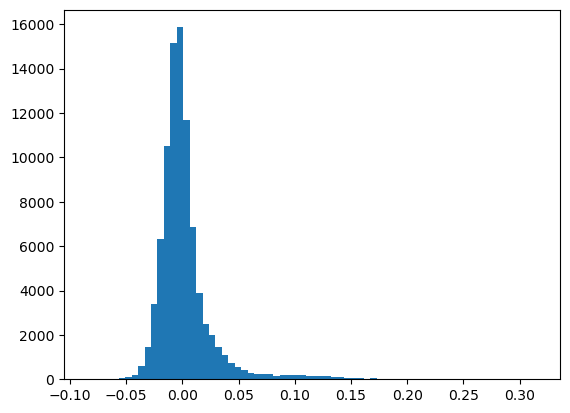

In [12]:
# Hist by all context, layers and heads

plt.hist(all_losses.flatten().cpu(), bins=70)
plt.show()

In [72]:
mean_all_losses.cpu().shape

torch.Size([32, 32])

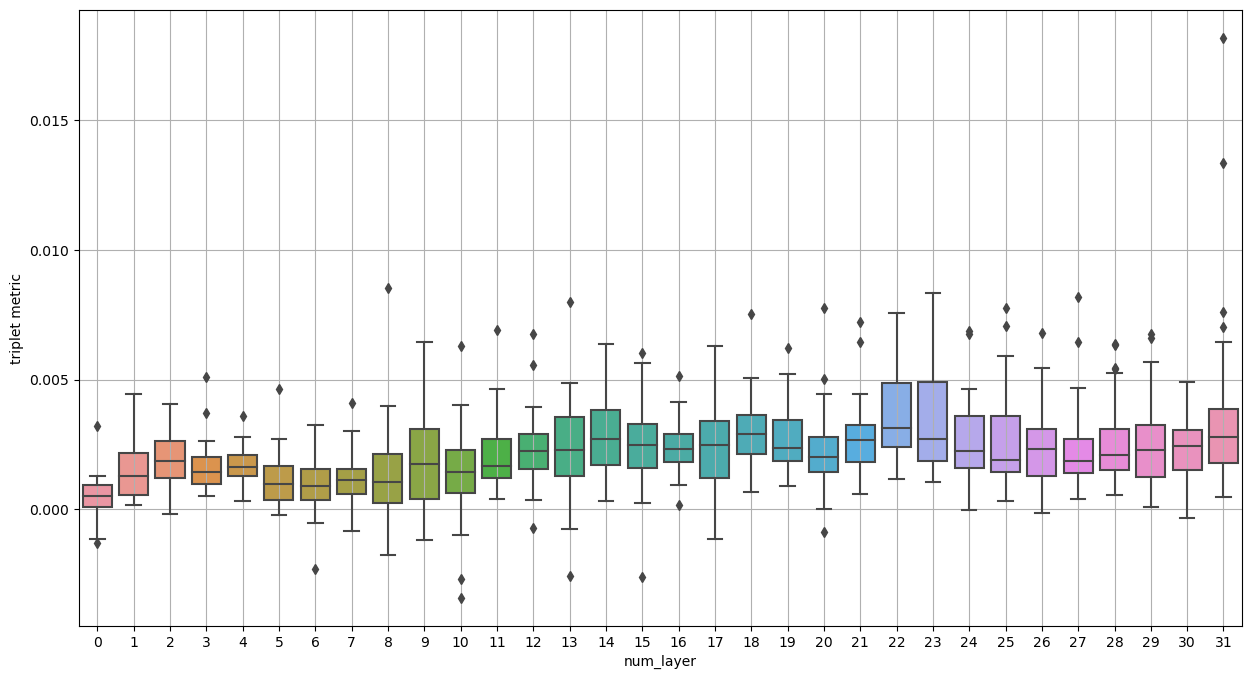

In [14]:
mean_all_losses = all_losses.mean(dim=0)
mean_all_losses = pd.DataFrame(mean_all_losses.cpu().numpy().T)
plt.figure(figsize=(15,8))
sns.boxplot(data=mean_all_losses.melt(), x='variable', y='value')
plt.xlabel('num_layer')
plt.ylabel('triplet metric')
plt.grid()

In [41]:
all_losses.mean(dim=0)[-1].argsort(descending=True)

tensor([29, 14,  3, 26, 10,  6, 18, 25, 17, 24,  0,  7, 28,  1, 30, 11,  8, 16,
         4, 15,  9, 22, 23,  5, 31, 27, 19, 13, 20, 12, 21,  2],
       device='cuda:0')

### Context+Query - Context+Query

![](./imgs/cont.jpeg)

In [29]:
from sklearn.model_selection import LeaveOneOut
from itertools import product
from tqdm.notebook import tqdm

all_losses2 = []
for curr_df in tqdm(nice_df.groupby('context')):
    curr_df = curr_df[1]
    pos_qa = curr_df.loc[~curr_df['is_impossible'], 'question'].to_list()
    pos_con = curr_df.loc[~curr_df['is_impossible'], 'context'].to_list()
    impos_qa = curr_df.loc[curr_df['is_impossible'], 'question'].to_list()  
    impos_con = curr_df.loc[curr_df['is_impossible'], 'context'].to_list()  

    stacked_pos = torch.stack([ret_queries(f'{con} {qa}')[:, :, -1, :] for con, qa in zip(pos_con, pos_qa)], dim=2)
    stacked_impos = torch.stack([ret_queries(f'{con} {qa}')[:, :, -1, :] for con, qa in zip(impos_con, impos_qa)], dim=2)

    loo = LeaveOneOut()

# avr-pos, 1 anchor,  3 neg 
    curr_triples = []
    for (train_idx, test_idx), impos_idx in product(loo.split(pos_qa), range(len(impos_qa))):
        # print(train_idx, test_idx, impos_idx)
        curr_anch = stacked_pos.index_select(2, torch.tensor(train_idx).cuda())
        curr_anch = curr_anch.mean(2)
        curr_pos = stacked_pos[:, :, test_idx[0], :]
        curr_neg = stacked_impos[:, :, impos_idx, :]

        # print(curr_pos.shape, curr_anch.shape, curr_neg.shape)
        loss = triplet_cosine(curr_anch, curr_pos, curr_neg)    
        # print(loss.shape)
        curr_triples.append(loss)
    curr_triples = torch.stack(curr_triples, dim=0)
    # print(curr_triples.shape)
    
    curr_mean_loss = curr_triples.mean(dim=0)
    all_losses2.append(curr_mean_loss)
    
all_losses2 = torch.stack(all_losses2, 0)
all_losses2.shape
    

  0%|          | 0/86 [00:00<?, ?it/s]

torch.Size([86, 32, 32])

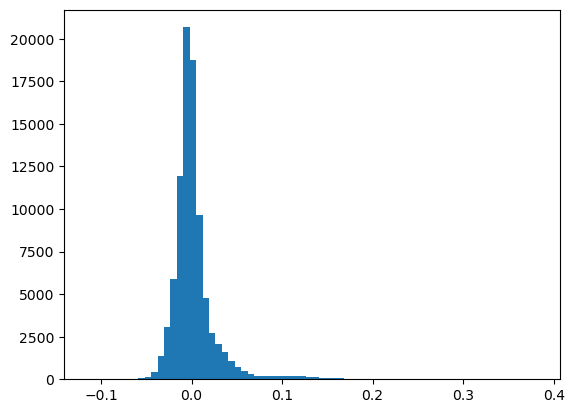

In [30]:
# Hist by all context, layers and heads

plt.hist(all_losses2.flatten().cpu(), bins=70)
plt.show()

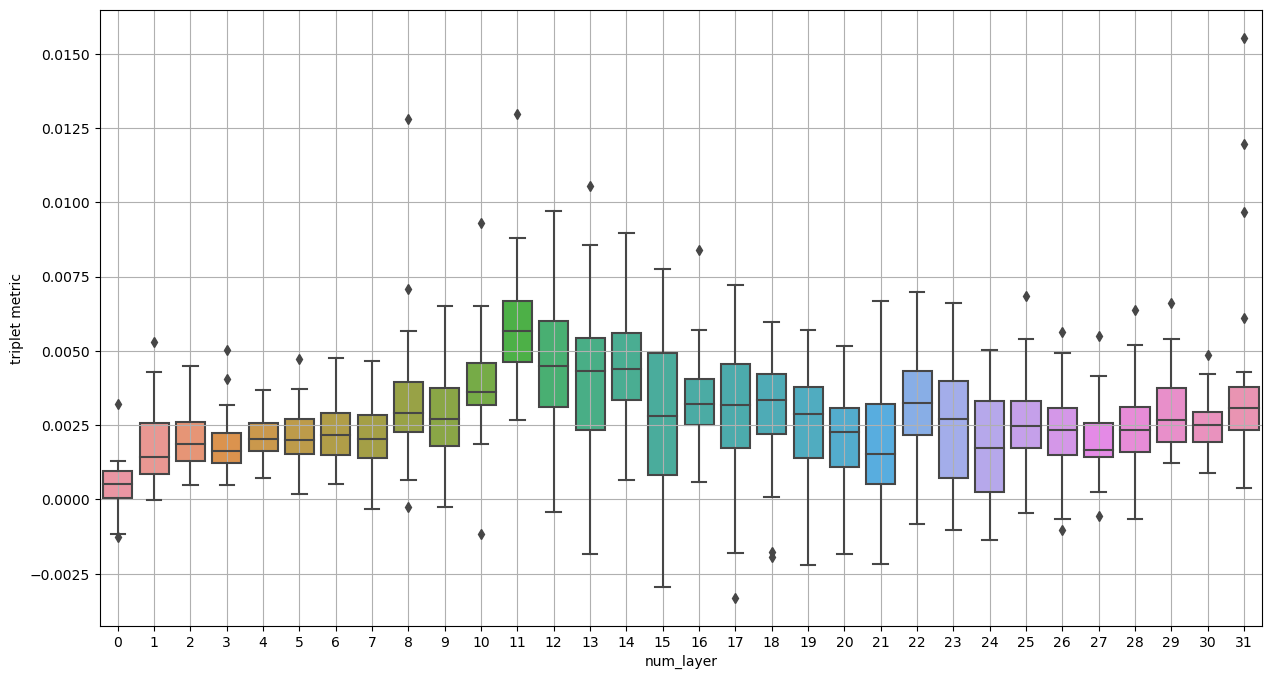

In [31]:
mean_all_losses = all_losses2.mean(dim=0)
mean_all_losses = pd.DataFrame(mean_all_losses.cpu().numpy().T)
plt.figure(figsize=(15,8))
sns.boxplot(data=mean_all_losses.melt(), x='variable', y='value')
plt.xlabel('num_layer')
plt.ylabel('triplet metric')
plt.grid()

In [42]:
all_losses2.mean(dim=0)[-1].argsort(descending=True)

tensor([29, 14,  3, 10, 25, 26,  7,  6,  8, 17,  1,  0,  5, 16, 24, 18, 15, 28,
        11,  9, 21, 19, 22, 30, 13, 31, 27,  4, 12,  2, 20, 23],
       device='cuda:0')

### SBERT

![](./imgs/sbert.jpeg)

In [92]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("all-roberta-large-v1")

def sbert_run(sent):
    sbert_model.encode(['adfad', 'aadfadf'], convert_to_numpy=False, device='cuda')

In [113]:
from sklearn.model_selection import LeaveOneOut
from itertools import product
from tqdm.notebook import tqdm

all_losses_sbert = []
for curr_df in tqdm(nice_df.groupby('context')):
    curr_df = curr_df[1]
    pos_qa = curr_df.loc[~curr_df['is_impossible'], 'question'].to_list()
    impos_qa = curr_df.loc[curr_df['is_impossible'], 'question'].to_list()  

    stacked_pos = torch.stack(sbert_model.encode(pos_qa, convert_to_numpy=False, device='cuda'), dim=0)
    stacked_impos = torch.stack(sbert_model.encode(impos_qa, convert_to_numpy=False, device='cuda'), dim=0)

    # print(stacked_pos.shape, stacked_impos.shape)
    loo = LeaveOneOut()

# avr-pos, 1 anchor,  3 neg 
    curr_triples = []
    for (train_idx, test_idx), impos_idx in product(loo.split(pos_qa), range(len(impos_qa))):
        # print(train_idx, test_idx, impos_idx)
        curr_anch = stacked_pos.index_select(0, torch.tensor(train_idx).cuda())
        curr_anch = curr_anch.mean(0)
        curr_pos = stacked_pos[test_idx[0], :]
        curr_neg = stacked_impos[impos_idx, :]

        # print(curr_pos.shape, curr_anch.shape, curr_neg.shape)
        loss = triplet_cosine(curr_anch, curr_pos, curr_neg, dim=-1)    
        # print(loss.shape)
        curr_triples.append(loss)
        # raise TypeError
    curr_triples = torch.stack(curr_triples, dim=0)
    # print(curr_triples.shape)
    
    curr_mean_loss = curr_triples.mean(dim=0)
    all_losses_sbert.append(curr_mean_loss)
    
all_losses_sbert = torch.stack(all_losses_sbert, 0)
all_losses_sbert.shape
    

  0%|          | 0/86 [00:00<?, ?it/s]

torch.Size([86])

In [115]:
all_losses_sbert = all_losses_sbert.cpu().numpy()
np.median(all_losses_sbert), np.mean(all_losses_sbert)

(0.008831605, 0.017942399)

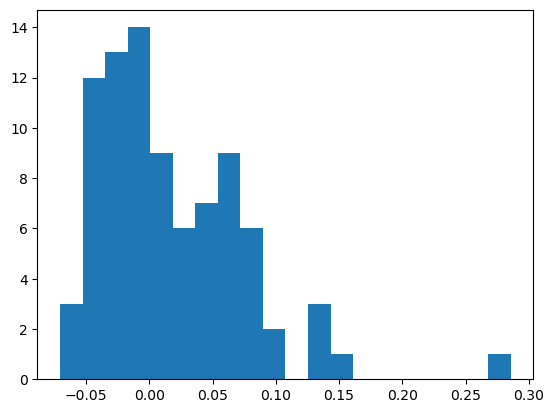

In [116]:
plt.hist(all_losses_sbert, bins=20)
plt.show()